In [1]:
#Math Part
import numpy as np
import pandas as pd

#Graph
import matplotlib.pyplot as plt

import importlib
import circuit
import encoding
import qsvm
import fitness
import gsvm
importlib.reload(circuit)
importlib.reload(encoding)
importlib.reload(qsvm)
importlib.reload(fitness)
importlib.reload(gsvm)

import pandas as pd
import time

def evol(output="sample_iot_result_n5.csv"):
    iot_data = pd.read_csv('sample_iot_data.csv')
    y = iot_data['pump'].values
    X = iot_data[['moisture','temp']].values
    start = time.time()
    pop, pareto, logbook = gsvm.gsvm(nqubits=6, depth=6, nparameters=2,
                                     X=X, y=y, weights=[-1.0,1.0],
                                     mu=50,lambda_=10, ngen=10000)
    print(f'Simulation finished after {time.time()-start} seconds')
    print(f'\nGenetic-algorithm output ({output})')
    #print('generation, individual, gates/qubit, accuracy')
    print('---------------------------------------------')
    with open(output, "w") as f:
        for ide, ind in enumerate(pareto):
            genes=''.join(str(i) for i in list(ind))
            gates, acc = ind.fitness.values
            line = f'{ide},"{genes}",{gates},{acc}'
            f.write(line)
            f.write('\n')
            print(line)
evol()

multi
gen	nevals	media	std      	max	min
0  	50    	0.941	0.0414608	1  	0.8
1  	10    	0.9405	0.0452465	1  	0.8
2  	10    	0.9385	0.048013 	1  	0.8
3  	10    	0.939 	0.0477389	1  	0.8
4  	10    	0.9445	0.0442408	1  	0.8
5  	10    	0.9425	0.0477624	1  	0.8
6  	10    	0.9405	0.0497217	1  	0.8
7  	10    	0.9415	0.0486338	1  	0.8
8  	10    	0.9465	0.0444438	1  	0.825
9  	10    	0.94  	0.0504975	1  	0.775
10 	10    	0.938 	0.0534416	1  	0.775
11 	10    	0.937 	0.0529717	1  	0.775
12 	10    	0.9415	0.0499024	1  	0.775
13 	10    	0.943 	0.0512445	1  	0.775
14 	10    	0.9365	0.0596259	1  	0.775
15 	10    	0.9395	0.0587559	1  	0.775
16 	10    	0.9445	0.0557427	1  	0.775
17 	10    	0.9455	0.0562783	1  	0.775
18 	10    	0.945 	0.0561249	1  	0.775
19 	10    	0.9435	0.0558592	1  	0.775
20 	10    	0.9435	0.0560825	1  	0.775
21 	10    	0.944 	0.0562494	1  	0.775
22 	10    	0.943 	0.0559106	1  	0.775
23 	10    	0.9445	0.052747 	1  	0.775
24 	10    	0.9455	0.0530778	1  	0.775
25 	10    	0.947 	0.051146

In [2]:
import encoding2 as e2
import random

iot_result = pd.read_csv('sample_iot_result_n5.csv',header=None)

def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','acc']
    dataframe.sort_values(['acc','gates'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,acc
0,253,0100001011010001011001000110001011010000010010...,1.000000,1.00
1,254,0100001011010001011001000010001011010000010010...,1.000000,1.00
2,255,0100001011010001011101000010001011010000010010...,1.000000,1.00
3,256,0100001011010011011001000110001011010000010010...,1.000000,1.00
4,257,0100001011010011011001000010001011010000010010...,1.000000,1.00
...,...,...,...,...
297,123,0100001011010111011001000110001011011000010010...,0.260417,0.75
298,124,0100001011010001011111001110001011011000010010...,0.260417,0.75
299,125,0101001001010111011111000110001011011000010010...,0.260417,0.75
300,126,0100001011010001010111001110001011011000010010...,0.260417,0.75


['01000', '01011', '01000', '10110', '01000', '11000', '10110', '10000', '01001', '01010', '11011', '11000', '10111', '01001', '10100', '01000', '01000', '11000', '01001', '11000', '11001', '10100', '10100', '01110', '01000', '10101', '01010', '01011', '01010', '10000', '11011', '01000', '10110', '11010', '11000', '01000']
3.0


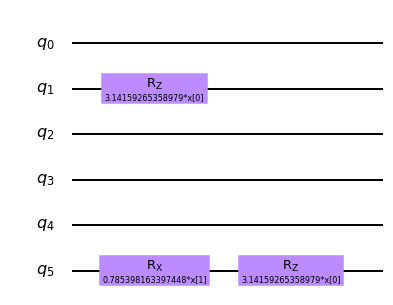

In [3]:
from qiskit.circuit import ParameterVector, QuantumCircuit, Parameter
from qiskit import execute, Aer, IBMQ, QuantumRegister, ClassicalRegister, BasicAer
from qiskit.aqua import QuantumInstance
def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

import os
import psutil

class Fitness:

    def __init__(self, nqubits, nparameters, X, y, quantum_instance):
        self.nqubits = nqubits
        self.nparameters = nparameters
        self.cc = CircuitConversor(nqubits, nparameters)
        self.instance = quantum_instance
        self.X = X
        self.y = y

    def __call__(self, POP):
        try:
            return self.fitness(POP)
        except Exception as e:
            print(f'Exception happened during fitness():\n  {e}')
            process = psutil.Process(os.getpid())
            print(f'  RUSAGE_SELF: {process.memory_info()}')
        return 1000, 100000.0

    def fitness(self, POP):
        print('Invoked fitness')
        #Convertimos el individuo en el fenotipo (ansatz)
        fm, puertas = self.cc(coding_bits(POP))
        
cc = CircuitConversor(nqubits=6, nparameters=2)
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')